In [218]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import time

## Model Configuration

In [219]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 2
    n_heads: int = 4
    n_kv_heads: Optional[int] = 4
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 8

    epochs: int = 5_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=2, n_heads=4, n_kv_heads=4, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=128, epochs=5000)


## Prepare Data

In [220]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [221]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [222]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f'Initialized RoPE with shape {self.freqs_cis.shape}')
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]]
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [223]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Initialized RoPE with shape torch.Size([256, 64])
True


### Feed-Forward Networks with SwiGLU

- [Paper](https://arxiv.org/pdf/2002.05202.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L307)

In [224]:
from typing import Optional

class FFN_SwiGLU(nn.Module):
    def __init__(
            self,
            config: ModelArgs,
        ):
        """
        Args:
            dim (int): Input dimension.
            hidden_dim (int): Hidden dimension of the feedforward layer.
            multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
            ffn_dim_multiplier (float, optional): Custom multiplier for hidden dimension. Defaults to None.

        Attributes:
            w1 (ColumnParallelLinear): Linear transformation for the first layer.
            w2 (RowParallelLinear): Linear transformation for the second layer.
            w3 (ColumnParallelLinear): Linear transformation for the third layer.

        """
        super().__init__()
        hidden_dim = (config.dim * 4) * 2 // 3
        # custom dim factor multiplier
        if config.ffn_dim_multiplier is not None:
            hidden_dim = config.ffn_dim_multiplier * hidden_dim
        hidden_dim = config.multiple_of * ((hidden_dim + config.multiple_of - 1) // config.multiple_of)

        self.w = nn.Linear(config.dim, hidden_dim, bias=False)
        self.v = nn.Linear(config.dim, hidden_dim, bias=False)
        self.w_2 = nn.Linear(hidden_dim, config.dim, bias=False)

    def forward(self, x):
        return self.w_2(F.silu(self.w(x)) * self.v(x))

### Attention

*Note:* 2 differences with the [original Llama implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L176)
- The weight matrix has 3 dimensions as: `(number_head * model_dimension * head_dimension)` instead of `(model_dimension * model_dimension)`. This is strictly follow the "Attention is all you need" paper
- For Group Query Attention implmentation, instead of repeating KV values which is against the purpose of GQA (to reduce KV load overhead). Here reshapes the Q/K/V to 5 dimensions: `(batch_size * number_kv_heads * number_shared_kv (number_heads/number_kv_heads) * sequence_length * head_dimension)` and do matmut()

In [225]:
n_heads = 8
n_kv_heads = 2
batch_size = 1
seq_len = 5
model_dim = 16
head_dim = model_dim // n_heads

w_q = nn.Parameter(torch.ones(n_heads,model_dim, head_dim) * 0.1)
w_k = nn.Parameter(torch.ones(n_kv_heads,model_dim, head_dim) * 0.2)
w_v = nn.Parameter(torch.ones(n_kv_heads,model_dim, head_dim) * 0.3)

x = torch.zeros(batch_size, seq_len, model_dim)
x[:, 1, :] = 1
x[:, 2, :] = 2
x[:, 3, :] = 3
x[:, 4, :] = 4
x = x[:, :-2]

q = (x.unsqueeze(1) @ w_q)
q = q.view(batch_size, n_kv_heads, -1, q.shape[-2], head_dim)
k = (x.unsqueeze(1) @ w_k)
k = k.view(batch_size, n_kv_heads, -1, k.shape[-2], head_dim)
v = (x.unsqueeze(1) @ w_v)
v = v.view(batch_size, n_kv_heads, -1, v.shape[-2], head_dim)
s = (q @ k.transpose(-2, -1))
o = F.scaled_dot_product_attention(q, k, v, dropout_p = 0.1, is_causal = True)
out = o.permute(0, 3, 1, 2, 4).contiguous().view(batch_size, x.shape[-2], -1)

print(x.shape, q.shape, k.shape, v.shape, s.shape, o.shape, out.shape)



torch.Size([1, 3, 16]) torch.Size([1, 2, 4, 3, 2]) torch.Size([1, 2, 1, 3, 2]) torch.Size([1, 2, 1, 3, 2]) torch.Size([1, 2, 4, 3, 3]) torch.Size([1, 2, 4, 3, 2]) torch.Size([1, 3, 16])


In [226]:
class Attention(nn.Module):
    """Multi-head attention module."""

    shared_rope : RoPE = None    

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        self.head_dim = config.dim // config.n_heads
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(self.head_dim, config.max_seq_len)

        self.w_q = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_k = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_v = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads,config.dim, self.head_dim),
                                                        mode='fan_out', nonlinearity='relu'))
        self.w_o = nn.Parameter(nn.init.kaiming_normal_(torch.empty(config.n_heads* self.head_dim, config.dim),
                                                        mode='fan_out', nonlinearity='relu'))

        self.cache_k = torch.zeros(config.max_batch_size, config.n_kv_heads, config.max_seq_len, self.head_dim, requires_grad=False)
        self.cache_v = torch.zeros_like(self.cache_k, requires_grad=False)
        self.dropout = nn.Dropout(.1)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        """
        x: (batch_size, seq_len, dim)
        q: (batch_size, n_heads, seq_len, head_dim)
        k: (batch_size, n_heads, seq_len, head_dim)
        v: (batch_size, n_heads, seq_len, head_dim)
        """
        q = x.unsqueeze(1) @ self.w_q
        k = x.unsqueeze(1) @ self.w_k
        v = x.unsqueeze(1) @ self.w_v

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)

        if self.training:       # apply dropout only during training
            dropout_p = 0.1            
        else:            
            self.cache_k[:, :, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, :, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :, :start_pos + x.shape[-2]]

            dropout_p = 0
        
        if x.shape[-2] == 1:    # if only one token, then not causal            
            is_causal = False
        else:
            is_causal = True

        # split heads and reshape Q, K, V as (batch_size, kv_heads, n_heads//kv_heads, seq_len, head_dim)
        q = q.view(self.config.max_batch_size, self.config.n_kv_heads, -1, q.shape[-2], self.head_dim)
        k = k.view(self.config.max_batch_size, self.config.n_kv_heads, -1, k.shape[-2], self.head_dim)
        v = v.view(self.config.max_batch_size, self.config.n_kv_heads, -1, v.shape[-2], self.head_dim)
        
        o = F.scaled_dot_product_attention(q, k, v, dropout_p = dropout_p, is_causal = is_causal)
        # o = o.permute(0, 2, 1, 3).contiguous().view(o.shape[0], o.shape[2], -1)       # concatenate heads        
        o = o.permute(0, 3, 1, 2, 4).contiguous().view(o.shape[0], o.shape[3], -1)       # concatenate heads
        o = o @ self.w_o
        o = self.dropout(o)

        return o

In [228]:
from collections import OrderedDict

class Llama2Block(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = Attention(config)
        self.attention_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_norm = RMSNorm(config.dim, eps = config.norm_eps)
        self.ffn_swiglu = FFN_SwiGLU(config)

    def forward(self, x, start_pos) -> torch.tensor:
        x = x + self.attention(self.attention_norm(x), start_pos)
        out = x + self.ffn_swiglu(self.ffn_norm(x))

        return out

class Llama2(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        
        Attention.shared_rope = None    # clear the shared rope defined in Attention class

        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", Llama2Block(config)) for i in range(config.n_layers)])
        )
        self.norm = RMSNorm(config.dim)
        self.output = nn.Linear(config.dim, config.vocab_size, bias=False)

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        h = self.embeddings(idx)

        for block in self.llama_blocks:
            h = block(h, start_pos)

        h = self.norm(h)
        logits = self.output(h)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [229]:
import pandas as pd

@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama2):
    config = model.config
    out = {}
    is_training = model.training

    if is_training:
        model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    if is_training:
        model.train()

    return out

def train(model: Llama2, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())            

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

Initialized RoPE with shape torch.Size([128, 16])
model params: 541824


Epoch 0 | val loss 4.133 | Time 0.216 | ETA in seconds 10.798
Epoch 100 | val loss 2.326 | Time 7.915 | ETA in seconds 387.851
Epoch 200 | val loss 2.090 | Time 9.204 | ETA in seconds 441.786
Epoch 300 | val loss 1.961 | Time 8.790 | ETA in seconds 413.117
Epoch 400 | val loss 1.867 | Time 8.580 | ETA in seconds 394.694
Epoch 500 | val loss 1.815 | Time 10.294 | ETA in seconds 463.224
Epoch 600 | val loss 1.784 | Time 9.449 | ETA in seconds 415.743
Epoch 700 | val loss 1.747 | Time 10.010 | ETA in seconds 430.423
Epoch 800 | val loss 1.738 | Time 9.387 | ETA in seconds 394.252
Epoch 900 | val loss 1.694 | Time 9.442 | ETA in seconds 387.106
Epoch 1000 | val loss 1.665 | Time 9.543 | ETA in seconds 381.717
Epoch 1100 | val loss 1.679 | Time 9.361 | ETA in seconds 365.065
Epoch 1200 | val loss 1.674 | Time 9.554 | ETA in seconds 363.042
Epoch 1300 | val loss 1.663 | Time 9.514 | ETA in seconds 352.011
Epoch 1400 | val loss 1.660 | Time 9.548 | ETA in seconds 343.717
Epoch 1500 | val loss

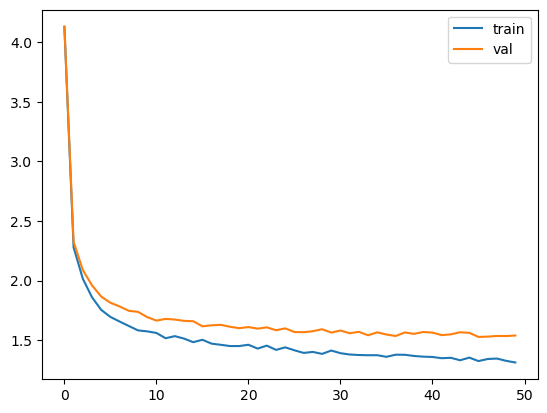

In [230]:
%%time

from datetime import datetime

llama = Llama2(model_config)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, print_logs=True)

# Save
now = datetime.now()
model_name = f'./checkpoint/llama2_L{model_config.n_layers}xH{model_config.n_heads}xN{model_config.max_seq_len}xD{model_config.dim}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [231]:
@torch.no_grad()
def generate(model : Llama2, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        if i == 0:
            logits = model(idx)
        else:
            logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            # logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [232]:
import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]

llama_infer = Llama2(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

Initialized RoPE with shape torch.Size([128, 16])
model params: 541824


<All keys matched successfully>

In [233]:
%%time

for s in generate(llama_infer, 100):
    print(s)


Is all or ignoble hear
Your highly indred: for they villain,
Sit will the plague my furn sweetly
Tha

tarding thee of our more end summers presence.

BRUTUS:
Are you any gentle shut, then days ob a thun

Is prayers, something of that? Corioli young to a persont.

JULIET:
Then fruing the prayer-hand not 


Hath he? Cry Richard, and bridable, with
Rhom when I'ld thousand'st to burst be or no
he sad ne'er 

GLOUCESTER:
What said his will stay he willed with the palment of God Camillo:
You no: and shall do 

Sirrt what you man ill the glove deads,
But fear in ready. The king on that best him;
Stay, sorrow s

EAll, let for itsenchering to the hope that we?
And I'ld please of your son, where it in these
that 

Shocad incents loves come to deserves,
With whom for my brawn, pleasured and the
Lone him ateth thee


AGBENVOLIO:
Did Clifford, and traords, steed, which hands,
Thou hadst stain me him and the prince,




That's nothing?

STANLEY:
My change ha!
What steps noble where I did, garlant;
